# Phone taped to a bicycle crank Kalman filter testing
Jotham Gates

## Forward
The phone taped to a bicycle crank knows where it likely is at all times. It knows this because it knows where it probably isn't. By subtracting where thinks it is from where it likely isn't, or where it hopefully isn't from where it is (whichever is greater), it obtains a difference, or deviation. The guidance subsystem uses deviations to generate corrective commands to drive the output from the phone taped to a bicycle crank from a position where it isn't to a position where it might, and arriving at a position where it wasn't, it now is. Consequently, the position where it is likely, is now the position that it wasn't, and it follows that the position that it thought it was, is now the position that it isn't with a high degree of confidence.

In the event that the position that it is in is not the position that it wasn't, the system has acquired a variation, the variation being the difference between where the phone taped to a bicycle crank is, and where it wasn't. If variation is considered to be a significant factor, like when the rider rides off a cliff, it too may be corrected by the Kalman filter. However, the phone taped to a bicycle crank must also know where it was.
The phone taped to a bicycle crank's Kalman filter works as follows. Because a variation has modified some of the information the phone taped to a bicycle crank has obtained, it is not sure just where it is. However, it is sure where it isn't, within reason, and it knows where it was. It now subtracts where it should be from where it wasn't, or vice-versa, and by differentiating this from the algebraic sum of where it shouldn't be, and where it was, it is able to obtain the deviation and its variation, which is called error.

## Imports and setup

In [1]:
# Imports and setup
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from sympy.stats import Normal, cdf, density, Binomial, ContinuousRV, DiscreteRV, P, E
import cmath as cm
from IPython.display import display, Markdown
from enum import Enum
import pandas as pd

sp.init_printing()
%matplotlib widget
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

## Importing and converting times to a convenient format
- Looks like the phone went from right foot forward ($x=+, y=0, z=0$) to right foot up ($x=0, y=+, z=0$) at $t=61$.
- Also note the drift in the $x$ and $y$ axis at high speeds just before $t=200s$ due to the accelerometer not being in the centre of rotation.

In [2]:
def plot_xyz(table, label, title, show_x=True, show_y=True, show_z=True):
    plt.close()
    plt.figure()
    # Being lazy and evil with if statements
    show_x and plt.plot(table["time"].values, table["x"].values, "r", label="$x$")
    show_y and plt.plot(table["time"].values, table["y"].values, "g", label="$y$")
    show_z and plt.plot(table["time"].values, table["z"].values, "b", label="$z$")
    plt.legend()
    plt.xlabel("Time [$s$]")
    plt.ylabel(label)
    plt.title(title)
    plt.show()

### From a phone

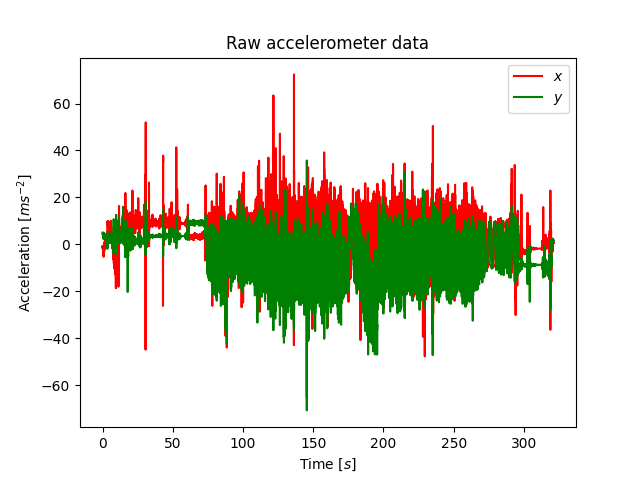

In [3]:
accel = pd.read_csv("../../../PedalAccelDataProcessing/AccelerometerUncalibrated.csv")
# accel = pd.read_csv("/home/jotham/Documents/Uni/FYP/PedalAccelDataProcessing/old_test/Accelerometer.csv")
offset = accel["time"].values[0]
accel["time"] = (accel["time"] - offset) / 1e9
accel.drop('seconds_elapsed', axis=1, inplace=True)
plot_xyz(accel, "Acceleration [$ms^{-2}$]", "Raw accelerometer data", show_z=False)

In [4]:
accel

,time,z,y,x
0,0.000000,8.250718,4.996998,-0.718261
1,0.002000,8.255507,4.982633,-0.730232
2,0.003974,8.245930,4.956297,-0.739808
3,0.005974,8.243536,4.939538,-0.742203
4,0.007983,8.233959,4.922778,-0.751779
...,...,...,...,...
160521,321.038065,10.055946,1.632846,0.502782
160522,321.040065,10.122984,1.666364,0.462081
160523,321.042065,10.170868,1.656788,0.469264
160524,321.044066,10.271424,1.618480,0.505177


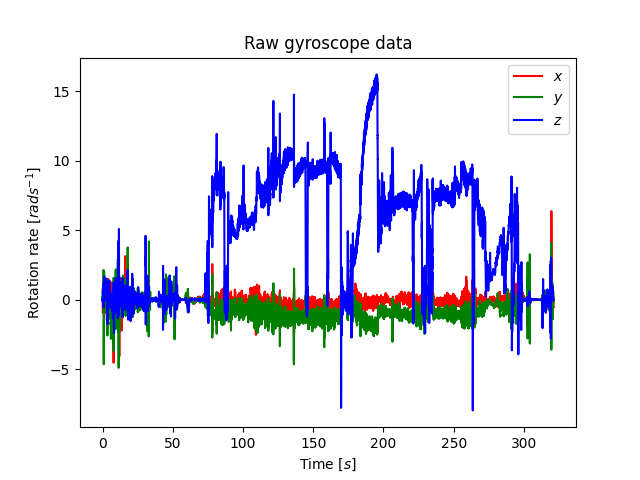

No such comm: 79f554bbc746493f82b5252f289396bd


In [5]:
gyro = pd.read_csv("../../../PedalAccelDataProcessing/GyroscopeUncalibrated.csv")
# gyro = pd.read_csv("/home/jotham/Documents/Uni/FYP/PedalAccelDataProcessing/old_test/Gyroscope.csv")
gyro["time"] = (gyro["time"] - offset) / 1e9
gyro.drop('seconds_elapsed', axis=1, inplace=True)
plot_xyz(gyro, "Rotation rate [$rad s^{-1}$]", "Raw gyroscope data")

In [6]:
gyro

,time,z,y,x
0,0.000000,-0.048869,0.160658,-0.093462
1,0.002000,-0.054367,0.158214,-0.095295
2,0.003974,-0.065363,0.157603,-0.093462
3,0.005974,-0.065363,0.157603,-0.093462
4,0.007983,-0.073304,0.160047,-0.090408
...,...,...,...,...
160521,321.038065,-0.020769,0.450208,-0.567494
160522,321.040065,-0.015272,0.491136,-0.579100
160523,321.042065,-0.014661,0.511905,-0.580933
160524,321.044066,-0.008552,0.529009,-0.572992


### Check the timestamps match between the gyroscope and accelerometer

In [7]:
times = accel["time"].values

array([0.00000000e+00, 2.00020000e-03, 3.97420000e-03, ...,
       3.21042065e+02, 3.21044066e+02, 3.21046065e+02])

In [8]:
if not np.alltrue(gyro["time"].values == accel["time"].values):
    print("Accelerometer and gyroscope have different times")
else:
    print("Accelerometer and gyroscope have the same times")

AttributeError: module 'numpy' has no attribute 'alltrue'

### Merge into one table

In [9]:
# Merge into one table.
data = accel.merge(gyro, how="inner", on="time", suffixes=("_accel", "_gyro"))

,time,z_accel,y_accel,x_accel,z_gyro,y_gyro,x_gyro
0,0.000000,8.250718,4.996998,-0.718261,-0.048869,0.160658,-0.093462
1,0.002000,8.255507,4.982633,-0.730232,-0.054367,0.158214,-0.095295
2,0.003974,8.245930,4.956297,-0.739808,-0.065363,0.157603,-0.093462
3,0.005974,8.243536,4.939538,-0.742203,-0.065363,0.157603,-0.093462
4,0.007983,8.233959,4.922778,-0.751779,-0.073304,0.160047,-0.090408
...,...,...,...,...,...,...,...
160521,321.038065,10.055946,1.632846,0.502782,-0.020769,0.450208,-0.567494
160522,321.040065,10.122984,1.666364,0.462081,-0.015272,0.491136,-0.579100
160523,321.042065,10.170868,1.656788,0.469264,-0.014661,0.511905,-0.580933
160524,321.044066,10.271424,1.618480,0.505177,-0.008552,0.529009,-0.572992


### Load data from the actual unit

In [274]:
### From the actual unit
data = pd.read_csv("../python-clients/imu.csv")
offset = data["Timestamp [us]"].values[0]
data["Timestamp [us]"] = (data["Timestamp [us]"] - offset) / 1e6
data["z_accel"] = 0
data["x_gyro"] = 0
data["y_gyro"] = 0
data.rename(
    columns={
        "Timestamp [us]": "time",
        "Acceleration X [m/s^2]": "x_accel",
        "Acceleration Y [m/s^2]": "y_accel",
        "Gyro Z [rad/s]": "z_gyro"
    },
    inplace=True
    )
data

,time,Velocity [rad/s],Position [rad],x_accel,y_accel,z_gyro,z_accel,x_gyro,y_gyro
0,0.000000,-0.000597,0.019844,-1.301733,-2.020261,-0.001065,0,0,0
1,0.009815,-0.000436,0.019915,-1.301733,-2.015471,0.000000,0,0,0
2,0.019927,-0.000174,0.019990,-1.294548,-2.023853,0.000533,0,0,0
3,0.030021,-0.000415,0.020054,-1.293350,-2.019063,-0.001065,0,0,0
4,0.040182,-0.000590,0.020118,-1.295745,-2.021458,-0.001065,0,0,0
...,...,...,...,...,...,...,...,...,...
27152,272.856427,0.000257,0.803920,-0.559254,-2.252584,0.000000,0,0,0
27153,272.866484,-0.000100,0.804159,-0.546081,-2.264560,-0.001065,0,0,0
27154,272.876528,-0.000073,0.804405,-0.543686,-2.263363,0.000000,0,0,0
27155,272.886577,-0.000341,0.804641,-0.549674,-2.256177,-0.001065,0,0,0


## Offsets of the IMU in the phone relative to the centre of the axle
Guess based on [this teardown](https://www.ifixit.com/Teardown/Samsung+Galaxy+S10+and+S10e+Teardown/120331).
For an S10e, the IMU appears to be near the camera flash.

In [275]:
# In metres. Phone
imu_length_offset = 0.115
imu_width_offset = 0.02

# None
imu_length_offset = 0
imu_width_offset = 0
imu_radius_offset = np.sqrt(imu_length_offset**2 + imu_width_offset**2)

## Calculating angle based on acceleration
This uses the distance offsets and gyroscope-based velocity to correct for centripedal acceleration. This is because the IMU is not at the centre of rotation.

These calculations assume that the accelerometer is rotating entirely around the $z$ axis. This means that all $z$ axis acceleration is ignored.

In [276]:
data["x_corrected"] = data["x_accel"] - imu_width_offset*(data["z_gyro"]**2)
data["y_corrected"] = data["y_accel"] + imu_length_offset*(data["z_gyro"]**2)
data["centripedal_accel"] = imu_radius_offset*(data["z_gyro"]**2)

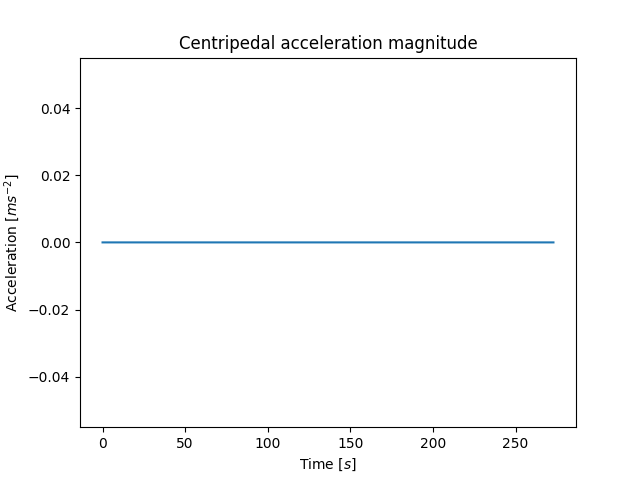

In [277]:
plt.close()
plt.figure()
plt.plot(data["time"].values, data["centripedal_accel"].values)
plt.xlabel("Time [$s$]")
plt.ylabel("Acceleration [$ms^{-2}$]")
# plt.legend()
plt.title("Centripedal acceleration magnitude")
plt.show()

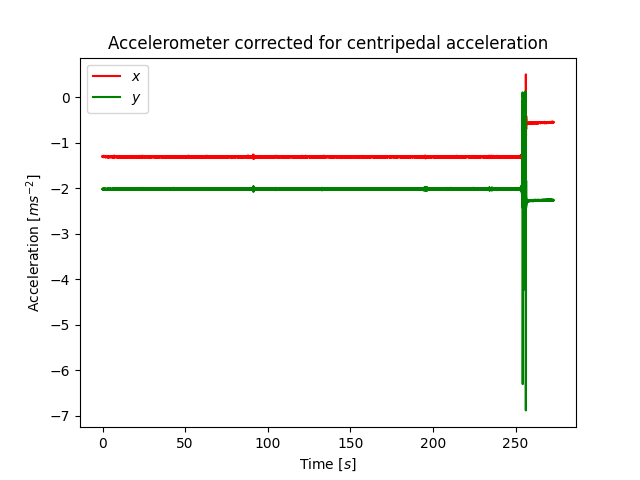

In [278]:
plt.close()
plt.figure()
plt.plot(data["time"].values, data["x_corrected"].values, "r", label="$x$")
plt.plot(data["time"].values, data["y_corrected"].values, "g", label="$y$")
plt.legend()
plt.xlabel("Time [$s$]")
plt.ylabel("Acceleration [$ms^{-2}$]")
plt.title("Accelerometer corrected for centripedal acceleration")
plt.show()

In [279]:
# data["theta_accel"] = np.arctan
angle = np.arctan(np.abs(data["y_corrected"] / data["x_corrected"]))
data.loc[(data["x_corrected"] >= 0) & (data["y_corrected"] >= 0), "theta_accel"] = angle # First quadrant
data.loc[(data["x_corrected"] < 0) & (data["y_corrected"] >= 0), "theta_accel"] = np.pi - angle # Second quadrant
data.loc[(data["x_corrected"] < 0) & (data["y_corrected"] < 0), "theta_accel"] = -np.pi + angle # Third quadrant
data.loc[(data["x_corrected"] >= 0) & (data["y_corrected"] < 0), "theta_accel"] = -angle # Fourth quadrant
data["theta_accel"] *= -1

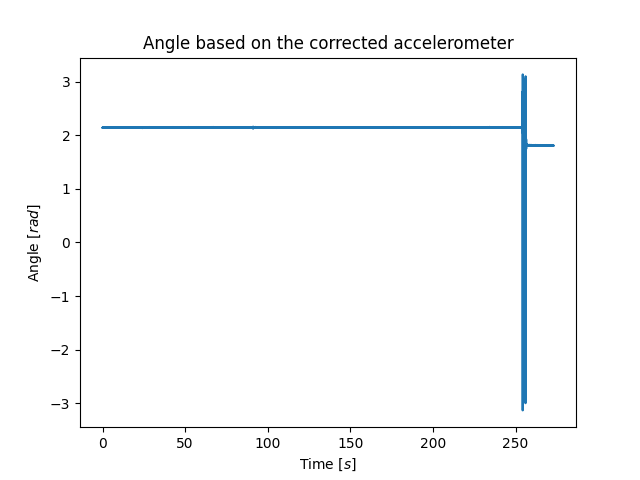

In [280]:
plt.close()
plt.figure()
plt.plot(data["time"].values, data["theta_accel"].values)
plt.xlabel("Time [$s$]")
plt.ylabel("Angle [$rad$]")
plt.title("Angle based on the corrected accelerometer")
plt.show()

In [281]:
data

,time,Velocity [rad/s],Position [rad],x_accel,y_accel,z_gyro,z_accel,x_gyro,y_gyro,x_corrected,y_corrected,centripedal_accel,theta_accel
0,0.000000,-0.000597,0.019844,-1.301733,-2.020261,-0.001065,0,0,0,-1.301733,-2.020261,0.0,2.143182
1,0.009815,-0.000436,0.019915,-1.301733,-2.015471,0.000000,0,0,0,-1.301733,-2.015471,0.0,2.144263
2,0.019927,-0.000174,0.019990,-1.294548,-2.023853,0.000533,0,0,0,-1.294548,-2.023853,0.0,2.139858
3,0.030021,-0.000415,0.020054,-1.293350,-2.019063,-0.001065,0,0,0,-1.293350,-2.019063,0.0,2.140513
4,0.040182,-0.000590,0.020118,-1.295745,-2.021458,-0.001065,0,0,0,-1.295745,-2.021458,0.0,2.140815
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27152,272.856427,0.000257,0.803920,-0.559254,-2.252584,0.000000,0,0,0,-0.559254,-2.252584,0.0,1.814148
27153,272.866484,-0.000100,0.804159,-0.546081,-2.264560,-0.001065,0,0,0,-0.546081,-2.264560,0.0,1.807421
27154,272.876528,-0.000073,0.804405,-0.543686,-2.263363,0.000000,0,0,0,-0.543686,-2.263363,0.0,1.806541
27155,272.886577,-0.000341,0.804641,-0.549674,-2.256177,-0.001065,0,0,0,-0.549674,-2.256177,0.0,1.809771


### Implementation

In [282]:
def limit_angles(value):
    # if value > np.pi:
    #     value -= 2*np.pi
    # elif value <= -np.pi:
    #     value += 2*np.pi
    # return value
    value = value % (2*np.pi)
    if value > np.pi:
        value -= 2*np.pi
    
    return value

def angle_diff(vector1, vector2):
    """Subtracts two thera-omega vectors from each other, wrapping around to use the shortest side of the circle.

    Args:
        vector1 (np.ndarray): The first vector to subtract.
        vector2 (np.ndarray): The second vector to subtract

    Returns:
        np.ndarray: vector1-vector2 taking into accound the cyclical nature of theta.
    """
    difference = vector1[0] - vector2[0]
    if abs(difference[0]) > np.pi:
        # Over 1/2 circle, can go around the other way.
        difference = 2*np.pi - difference
        
    result = np.array([
        difference,
        vector1[1] - vector2[1]
    ])
    return result


def kalman_step(x_prev:np.ndarray, p_prev:np.ndarray, time:float, env_uncertainty:np.ndarray, measured:np.ndarray, meas_uncertainty:np.ndarray):
    """A Kalman filter modified to work with angles.

    Args:
        x_prev (np.ndarray): The previous state as a 2 row, 1 column matrix (position on top, angular velocity below).
        p_prev (np.ndarray): The previous covariance matrix.
        time (float): The time step from the last call.
        env_uncertainty (np.ndarray): The environmental uncertainty covariance matrix.
        measured (np.ndarray): The measured values at this step.
        meas_uncertainty (np.ndarray): The covariance matrix representing the measured values' uncertainty.

    Returns:
        Tuple: the current position and current covariance matrix.
    """
    x_prev = x_prev.reshape(2, 1)
    # p_prev = p_prev.reshape(2, 1)
    # env_uncertainty = env_uncertainty.reshape(2, 1)
    measured = measured.reshape(2, 1)
    # meas_uncertainty = meas_uncertainty.reshape(2, 1)
    # Prediction
    fk = np.array([
        [1, time],
        [0, 1]
    ])
    x_predict = np.matmul(fk, x_prev) # Ignoring Bk u

    # Limit theta
    x_predict[0] = limit_angles(x_predict[0])
    
    p_predict = np.matmul(np.matmul(fk, p_prev), fk.transpose()) + env_uncertainty
    # return x_predict, p_predict
    # print(f"{p_predict=}")
    # Update
    hk = np.array([
        [1, 0],
        [0, 1]
    ])
    k_prime = p_predict.dot(hk.transpose()).dot(
        np.linalg.inv(
            hk.dot(p_predict).dot(hk.transpose()) + meas_uncertainty
        )
    )
    # temp = np.dot(np.dot(hk, p_predict), hk.T) + meas_uncertainty
    # k_prime = np.dot(np.dot(p_predict, hk.T), np.linalg.inv(temp))   
    # x_prime = x_predict + k_prime.dot(measured - hk.dot(x_predict))
    x_prime = x_predict + k_prime.dot(angle_diff(measured, hk.dot(x_predict)))
    p_prime = p_predict - k_prime.dot(hk).dot(p_predict)

    # temp2 = measured - np.dot(hk, x_predict)  
    # x_prime = x_predict + np.dot(k_prime, temp2)

    # I = np.eye(p_predict.shape[0])
    # p_prime = np.dot(np.dot(I - np.dot(k_prime, hk), p_predict), (I - np.dot(k_prime, hk)).T) + np.dot(np.dot(k_prime, meas_uncertainty), k_prime.T)

    x_prime[0] = limit_angles(x_prime[0])

    return x_predict, x_prime, p_prime

# Example
# kalman_step(
#     np.array([0, 10]),
#     np.array([
#         [0, 100],
#         [100, 0]
#     ]),
#     0.2,
#     np.array([10, 20]),
#     np.array([2, 13]),
#     np.array([0.1, 0.5])
# )

## Testing on the data

In [283]:
# Lists to save data in
thetas = np.zeros(shape=(len(data), 1))
omegas = np.zeros(shape=(len(data), 1))

# Initial states
x = np.array([[0], [0]]) # Starting position.
p = np.array([[1e4, 1e4], [1e4, 1e4]]) # Initially not confident where we are.

# Constants
env_uncertainty = np.array([[0.002, 0], [0, 0.01]]) # Probably will be somewhere near here, allows a bit to account for changing in speed.
meas_uncertainty = np.array([[1e4, 0], [0, 0.1]]) # Really not confident in the accelerometer, very confident in the gyroscope.

# Run the kalmin filter
for i in range(1, len(data)): # // 3 for quicker testing
    # Calculate parameters
    prev_row = data.loc[i-1]
    cur_row = data.loc[i]
    time = cur_row["time"] - prev_row["time"]
    meas = np.array([cur_row["theta_accel"], cur_row["z_gyro"]])

    # Do the step
    _, x, p = kalman_step(x, p, time, env_uncertainty, meas, meas_uncertainty)

    # Save the results for analysis later
    thetas[i] = x[0]
    omegas[i] = x[1]

In [284]:
data["theta"] = thetas
data["omega"] = omegas

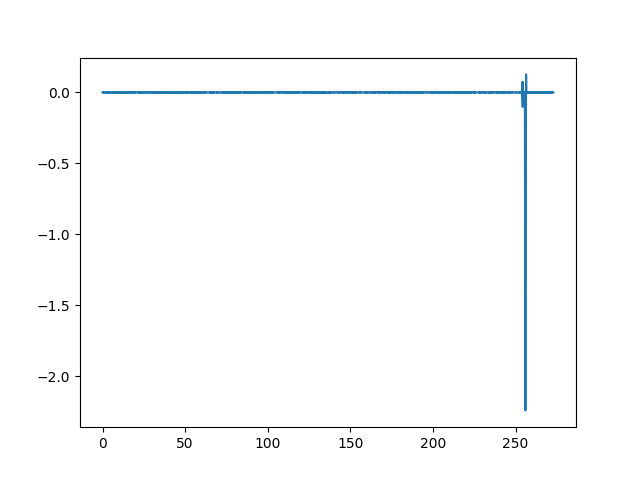

No such comm: 1ec0baed7ed64b528d3e131140fff959


In [285]:
plt.close()
plt.figure()
plt.plot(data["time"].values, data["omega"].values)
plt.show()

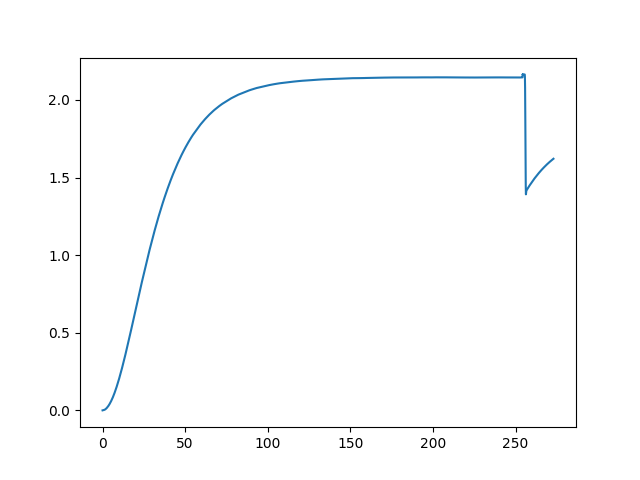

In [286]:
plt.close()
plt.figure()
plt.plot(data["time"].values, data["theta"].values)
plt.show()

## Integrating just the gyroscope

In [272]:
time_step = np.concatenate((np.array([0]), np.diff(data["time"])))
impulse = data["z_gyro"] * time_step
full_angle = impulse.cumsum()
data["theta_gyro"] = full_angle
data["theta_gyro"] -= 0.2 # Roughly zero the start
data["theta_gyro"] %= (2*np.pi)
data["theta_gyro"] -= np.pi
data

,time,Velocity [rad/s],Position [rad],x_accel,y_accel,z_gyro,z_accel,x_gyro,y_gyro,x_corrected,y_corrected,centripedal_accel,theta_accel,theta,omega,theta_gyro
0,0.000000,-0.000597,0.019844,-1.301733,-2.020261,-0.001065,0,0,0,-1.301733,-2.020261,0.0,2.143182,0.000000,0.000000,2.941593
1,0.009815,-0.000436,0.019915,-1.301733,-2.015471,0.000000,0,0,0,-1.301733,-2.015471,0.0,2.144263,0.000024,0.000022,2.941593
2,0.019927,-0.000174,0.019990,-1.294548,-2.023853,0.000533,0,0,0,-1.294548,-2.023853,0.0,2.139858,0.000288,0.000300,2.941598
3,0.030021,-0.000415,0.020054,-1.293350,-2.019063,-0.001065,0,0,0,-1.293350,-2.019063,0.0,2.140513,-0.000110,-0.000218,2.941587
4,0.040182,-0.000590,0.020118,-1.295745,-2.021458,-0.001065,0,0,0,-1.295745,-2.021458,0.0,2.140815,-0.000276,-0.000490,2.941576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22125,222.339412,-0.000440,0.995516,-1.305326,-2.019063,-0.000533,0,0,0,-1.305326,-2.019063,0.0,2.144708,2.144245,-0.000440,2.914699
22126,222.349381,-0.000177,0.995520,-1.301733,-2.015471,0.000533,0,0,0,-1.301733,-2.015471,0.0,2.144263,2.144248,-0.000177,2.914705
22127,222.359309,-0.000129,0.995519,-1.308918,-2.013075,0.000000,0,0,0,-1.308918,-2.013075,0.0,2.147318,2.144249,-0.000129,2.914705
22128,222.369361,0.000050,0.995523,-1.302930,-2.017865,0.000533,0,0,0,-1.302930,-2.017865,0.0,2.144141,2.144253,0.000050,2.914710


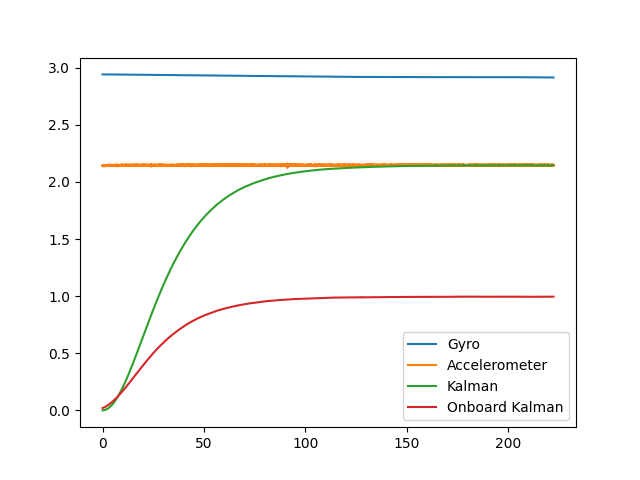

In [273]:
plt.close()
plt.figure()
plt.plot(data["time"].values, data["theta_gyro"].values, label="Gyro")
plt.plot(data["time"].values, data["theta_accel"].values, label="Accelerometer")
plt.plot(data["time"].values, data["theta"].values, label="Kalman")
plt.plot(data["time"].values, data["Position [rad]"].values, label="Onboard Kalman")
plt.legend()
plt.show()

## Plotting watt-bike style graphs

In [ ]:
def rad_per_s_to_rpm(values):
    return values / (2*np.pi) * 60

In [ ]:
def wattbike(start, stop, cad_lim=None):
    interested = data[(data["time"] >= start) & (data["time"] < stop)]
    plt.close()
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(interested["theta"].values, rad_per_s_to_rpm(interested["omega"].values))
    ax.set_title(f"Cadence [rpm] vs pedal angle [$^\circ$] between ${start}s$ and ${stop}s$")
    if cad_lim:
        ax.set_ylim(cad_lim)
    plt.show()

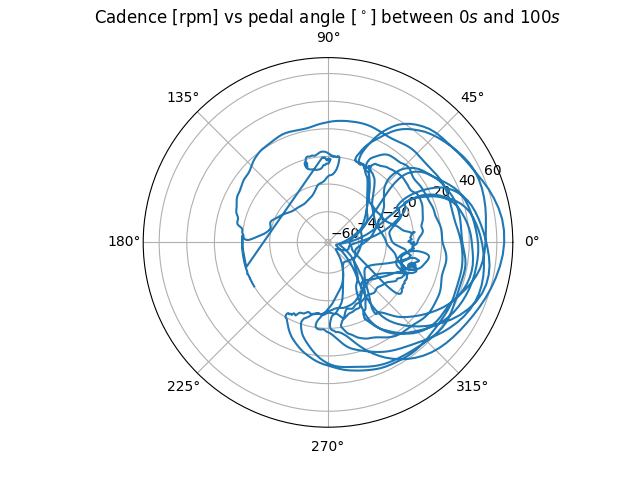

In [ ]:
# wattbike(130, 135, cad_lim=[90, 104])
# wattbike(130, 135)
wattbike(0, 100)

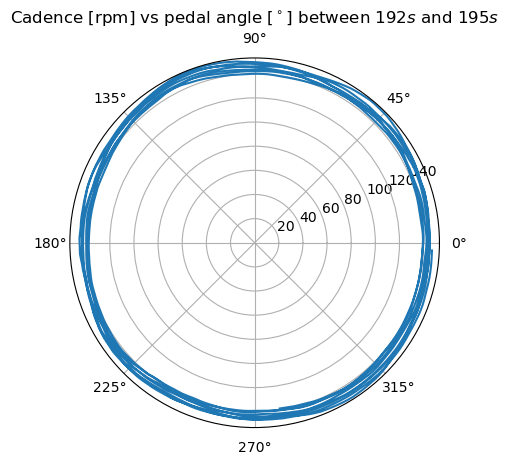

In [39]:
wattbike(192, 195)

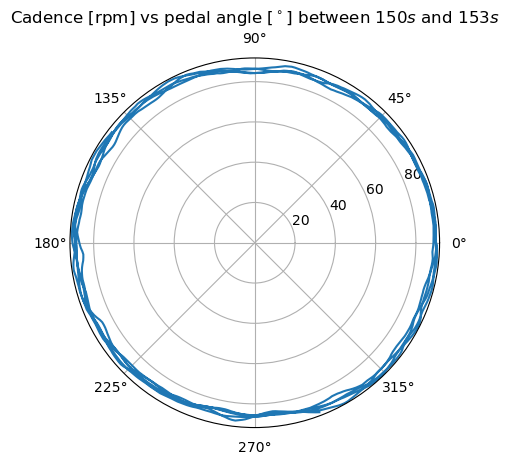

In [40]:
wattbike(150, 153)

## Kalman filter working out
- https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/ (My current favourite, many of the formulas are copied and pasted from this website,)
- https://medium.com/analytics-vidhya/kalman-filters-a-step-by-step-implementation-guide-in-python-91e7e123b968
- https://thekalmanfilter.com/kalman-filter-explained-simply/
- https://bps-space.github.io/control-theory/

$$
\begin{aligned}
\hat{\mathbf{x}} &= \left[ \begin{matrix}\theta \\ \omega \end{matrix} \right] \\
\mathbf{P}_k &= 
\begin{bmatrix} 
\Sigma_{\theta \theta} & \Sigma_{\theta \omega} \\ 
\Sigma_{\theta \omega} & \Sigma_{\omega \omega} \\ 
\end{bmatrix} 
\end{aligned}
$$

Where:
- $\hat{\mathbf{x}}$ is the state estimate.
- $\mathbf{P}_k$ is the covariance matrix (uncertaincy)

### Prediction step
$$
\begin{split} 
\theta_k &= \theta_{k-1} + \Delta t &\omega_{k-1} \\ 
\omega_k &= &\omega_{k-1}
\end{split}
$$

In matrix form:
$$
\begin{align} 
\mathbf{\hat{x}}_k &= \begin{bmatrix} 
1 & \Delta t \\ 
0 & 1 
\end{bmatrix} \mathbf{\hat{x}}_{k-1} \\ 
&= \mathbf{F}_k \mathbf{\hat{x}}_{k-1}
\end{align}
$$

In [ ]:
# NOTE: We need to correct for theta overflowing.

$$
\begin{equation} 
\begin{split} 
\color{deeppink}{\mathbf{\hat{x}}_k} &= \mathbf{F}_k \color{royalblue}{\mathbf{\hat{x}}_{k-1}} + \mathbf{B}_k \color{darkorange}{\vec{\mathbf{u}_k}} \\ 
\color{deeppink}{\mathbf{P}_k} &= \mathbf{F_k} \color{royalblue}{\mathbf{P}_{k-1}} \mathbf{F}_k^T + \color{mediumaquamarine}{\mathbf{Q}_k} 
\end{split} 
\end{equation}
$$

- We don't have any inputs to the system that we can easily model and want to keep things simple, so $\mathbf{B}_k \color{darkorange}{\vec{\mathbf{u}_k}} = 0$.
- $\color{mediumaquamarine}{\mathbf{Q}_k}$ is additional uncertainty from the environment.

### Update step

$$
\begin{split} 
\color{royalblue}{\mathbf{\hat{x}}_k’} &= \color{fuchsia}{\mathbf{\hat{x}}_k} + \color{purple}{\mathbf{K}’} ( \color{yellowgreen}{\vec{\mathbf{z}_k}} – \color{fuchsia}{\mathbf{H}_k \mathbf{\hat{x}}_k}) \\ 
\color{royalblue}{\mathbf{P}_k’} &= \color{deeppink}{\mathbf{P}_k} – \color{purple}{\mathbf{K}’} \color{deeppink}{\mathbf{H}_k \mathbf{P}_k} 
\end{split} 
$$


Where the Kalman gain, $\color{purple}{\mathbf{K}’}$ is:
$$
\color{purple}{\mathbf{K}’} = \color{deeppink}{\mathbf{P}_k \mathbf{H}_k^T} ( \color{deeppink}{\mathbf{H}_k \mathbf{P}_k \mathbf{H}_k^T} + \color{mediumaquamarine}{\mathbf{R}_k})^{-1} 
$$

### Sympy
#### Prediction

In [ ]:
# x and p
theta, omega = sp.symbols("\\theta_{k-1} \\omega_{k-1}")
p_theta, p_omega, p_theta_omega = sp.symbols("\\Sigma_{\\theta\\theta} \\Sigma_{\\omega\\omega} \\Sigma_{\\theta\\omega}")
x = sp.Matrix([theta, omega])
p = sp.Matrix([[p_theta, p_theta_omega], [p_theta_omega, p_omega]])

# Prediction matrix
t = sp.symbols("\Delta{t}_{k}")
f = sp.Matrix([[1, t], [0, 1]])

# Environmental uncertainty
q_theta, q_omega, q_theta_omega = sp.symbols("Q_{\\theta\\theta} Q_{\\omega\\theta} Q_{\\theta\\omega}")
q = sp.Matrix([[q_theta, q_theta_omega], [q_theta_omega, q_omega]])

# x prediction
x_predict = f*x

⎡\Delta{t}_{k}⋅\omega_{k-1} + \theta_{k-1}⎤
⎢                                         ⎥
⎣              \omega_{k-1}               ⎦

In [ ]:
# p prediction
p_predict = f*p*sp.transpose(f) + q

⎡Q_{\theta\theta} + \Delta{t}_{k}⋅\Sigma_{\theta\omega} + \Delta{t}_{k}⋅(\Delt ↪
⎢                                                                              ↪
⎣                                       Q_{\theta\omega} + \Delta{t}_{k}⋅\Sigm ↪

↪ a{t}_{k}⋅\Sigma_{\omega\omega} + \Sigma_{\theta\omega}) + \Sigma_{\theta\the ↪
↪                                                                              ↪
↪ a_{\omega\omega} + \Sigma_{\theta\omega}                                     ↪

↪ ta}  Q_{\theta\omega} + \Delta{t}_{k}⋅\Sigma_{\omega\omega} + \Sigma_{\theta ↪
↪                                                                              ↪
↪                         Q_{\omega\theta} + \Sigma_{\omega\omega}             ↪

↪ \omega}⎤
↪        ⎥
↪        ⎦

#### Refininement

In [ ]:
h = sp.Matrix([[1, 0], [0, 1]])
ht = sp.transpose(h)

# Measurement uncertainty
r_theta, r_omega, r_theta_omega = sp.symbols("R_{\\theta\\theta} R_{\\omega\\omega} R_{\\theta\\omega}")
r = sp.Matrix([[r_theta, r_theta_omega], [r_theta_omega, r_omega]])

# Calculate k prime
k_prime = p_predict*ht*(h*p_predict*ht + r).inverse()

⎡                                                                              ↪
⎢                                                                              ↪
⎢───────────────────────────────────────────────────────────────────────────── ↪
⎢                                                                              ↪
⎢Q_{\omega\theta}⋅Q_{\theta\theta} + Q_{\omega\theta}⋅R_{\theta\theta} + Q_{\o ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢───────────────────────────────────────────────────────────────────────────── ↪
⎢                                                                              ↪
⎣Q_{\omega\theta}⋅Q_{\theta\theta} + Q_{\omega\theta}⋅R_{\theta\theta} + Q_{\o ↪

↪                                                                              ↪
↪                          

In [ ]:
# Measured
z_theta, z_omega = sp.symbols("z_{\\theta} z_{\\omega}")
z = sp.Matrix([z_theta, z_omega])
x_prime = x_predict + k_prime * (z - h*x_predict)
x_prime = sp.simplify(x_prime)

⎡                              ⎛                                               ↪
⎢- (\omega_{k-1} - z_{\omega})⋅⎝(Q_{\theta\omega} + \Delta{t}_{k}⋅\Sigma_{\ome ↪
⎢───────────────────────────────────────────────────────────────────────────── ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎣                                                                              ↪

↪                                    ⎛                                         ↪
↪ ga\omega} + \Sigma_{\thet

In [ ]:
p_prime = p_predict - k_prime*h*p_predict
p_prime = sp.simplify(p_prime)

⎡                                                                              ↪
⎢Q_{\omega\theta}⋅Q_{\theta\theta}⋅R_{\theta\theta} + Q_{\omega\theta}⋅R_{\the ↪
⎢───────────────────────────────────────────────────────────────────────────── ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                   Q_{\omega\ ↪
⎢                                                                   ────────── ↪
⎢                                                                              ↪
⎣                                                                              ↪

↪                        2                                                     ↪
↪ ta\theta}⋅\Delta{t}_{k} ⋅

In [ ]:
subs_list = [
    (p_theta, 10e3),
    (p_theta_omega, 10e3),
    (p_omega, 10e3),
    (q_theta, 0.1),
    (q_omega, 2),
    (q_theta_omega, 1),
    (r_theta, 1),
    (r_theta_omega, 0.2),
    (r_omega, 0.1)
]
sp.simplify(x_prime.subs(subs_list))

⎡                      2                                   2                   ↪
⎢- 2000.0⋅\Delta{t}_{k} ⋅z_{\omega} + 21000.0⋅\Delta{t}_{k} ⋅z_{\theta} + 2001 ↪
⎢───────────────────────────────────────────────────────────────────────────── ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                 2                            ↪
⎢                            20000.0⋅\Delta{t}_{k} ⋅z_{\omega} + 1000.29999999 ↪
⎢                            ───────────────────────────────────────────────── ↪
⎢                                                                              ↪
⎣                                                                              ↪

↪                                                                              ↪
↪ .85999999464⋅\Delta{t}_{k

### Wrap up

Overview diagram stolen from [here](https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/)
![image.png](attachment:89f49d5e-5c48-49ea-9e29-a6cf55a59e0a.png)